In [1]:
#Bojana Ivanovic sw5/2015

import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections

# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

def select_roi(image_orig, image_bin):
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 5 and w > 15:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

/home/student/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


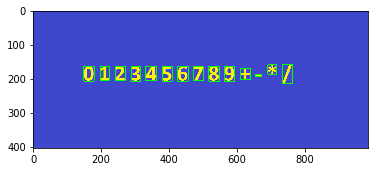

In [2]:
image_test = load_image('images/kalkulator_alfabet.png')
img_test = invert(image_bin(image_gray(image_test)))
img_test_bin = erode(dilate(img_test))
selected_reg_test, numbers_test = select_roi(image_test.copy(), img_test)
display_image(selected_reg_test)

In [3]:
alphabet = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '+', '-', '*', '/']
inputs = prepare_for_ann(numbers_test)
outputs = convert_output(alphabet)
ann = create_ann(len(alphabet))
train_ann_var = train_ann(ann, inputs, outputs,2000)


Training started...

Training completed...


In [4]:
def string_result(outputs, alphabet):
    result = ""
    for output in outputs:
        result = result + str(alphabet[winner(output)])
    return result


def calculate_str(string):
    return eval(string)

Resenje zadatka je:  5


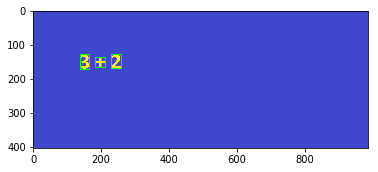

In [5]:
t1 = load_image('images/sbiranje.png')
imgt1 = invert(image_bin(image_gray(t1)))
img_bin_t1 = erode(dilate(imgt1))
selected_reg_t1, numbers_test1 = select_roi(t1.copy(), imgt1)
display_image(selected_reg_t1)

inputs1 = prepare_for_ann(numbers_test1)
result = ann.predict(np.array(inputs1, np.float32))

strResult = string_result(result, alphabet)
print('Resenje zadatka je: ', calculate_str(strResult))

Resenje zadatka je:  5


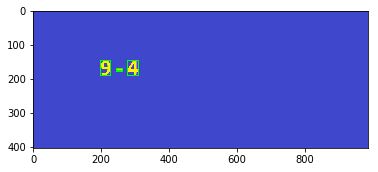

In [6]:
t2 = load_image('images/oduzimanje.png')
imgt2 = invert(image_bin(image_gray(t2)))
img_bin_t2 = erode(dilate(imgt2))
selected_reg_t2, numbers_test2 = select_roi(t2.copy(), imgt2)
display_image(selected_reg_t2)

inputs2 = prepare_for_ann(numbers_test2)
result = ann.predict(np.array(inputs2, np.float32))

strResult = string_result(result, alphabet)
print('Resenje zadatka je: ', calculate_str(strResult))

Resenje zadatka je:  8.0


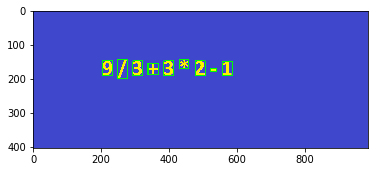

In [7]:
t3 = load_image('images/slozen_izraz.png')
imgt3 = invert(image_bin(image_gray(t3)))
img_bin_t3 = erode(dilate(imgt3))
selected_reg_t3, numbers_test3 = select_roi(t3.copy(), imgt3)
display_image(selected_reg_t3)

inputs3 = prepare_for_ann(numbers_test3)
result = ann.predict(np.array(inputs3, np.float32))

strResult = string_result(result, alphabet)
print('Resenje zadatka je: ', calculate_str(strResult))